**Import Modules**

In [1]:
import os
import sys
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd 
from typing import Union
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

from catops.catops.utils import *
from catops.catops.plotting import *
from catops.catops.geobalance import Voxels, reduce_event_count_per_voxel
from plotconf import matsettings

using numpy v1.20.2.
using pandas v1.2.4.


## GeoSpatialBalancing
### A notebook to reduce the spatial density of earthquakes in the Yellowstone catalog.

"Seismicity in the region is typical of volcanic systems and is characterized by shallow (<10 km) swarm activity [(Farrell et al., 2009)](https://doi.org/10.1016/j.jvolgeores.2009.08.008) intermingled with deeper (up to ~20 km) tectonic seismicity related to the intermountain seismic belt (ISB) (Smith and Arabasz, 1991), which crosscuts the Yellowstone plateau. Major swarm events include; ‘Autumn 1985 swarm’, Yellowstone Lake swarm (2008-2009), Madison Plateau swarm (2010) and Maple Creek swarm (2017-2018) ([Farrell *et al.*, 2009](https://doi.org/10.1016/j.jvolgeores.2009.08.008); [Massin et al., 2013](https://doi.org/10.1016/j.jvolgeores.2013.03.022); [Pang et al., 2019](https://doi.org/10.1029/2019GL082376); [Shelly and Hardebeck, 2019)](https://doi.org/10.1029/2018GL081607)."

-- <cite>Holt *et al.* (*in prep*)</cite>

The 'swarmy' nature of earthquakes recorded in Yellowstone National Park is of concern to local magnitude calibratation. Seismic swarms are spatio-termporally clustered, meaning they occur in very specific locations in Yellowstone over a reletively short time period. Since our catalog has a reasonably long time history, and we assume the large scale structure is not highly variable over this time period, we can focus on the spatial sampling. Since the network geometry is largely similar, we cannot have too many similar source-site paths from one location; this will bias the distance correction. We therefore come up with a simple strategy to limit the number of events that come from any given locale.<br>

Our approach is simple, we will :

1. Grid the Yellowstone region into $X$ slices in longitude and $Y$ slices in latitude and $Z$ depth slices.
2. Iterate through the subgrids of $(x,y,z)$ where $x$, $y$ and $z$ are the center coordinates for grid $n$ of $N_{grids}$, where $N_{grids} = XYZ$. 

Check if the number of earthquakes in n is $\geq$ the maximum permitted in a given subgrid $n$ ($E_{cap}$). If not, return to 2, else continue to 3.

3. Sort events by catalog magnitude ($CatMag$) and number of ampltiudes ($N_{amps}$) from highest to lowest in each catagory in that order of perference.

4. Sort removed events by most to least amplitudes and backfill with earthquakes from the top to bottom until you have $E_{cap}$ events.

### After the reduction is completed
Merge new spatially balanced catalog with the catalog of events with an $M_w$ from moment tensor inversion.

Global variables

In [2]:
# PDIR = "/uufs/chpc.utah.edu/common/home/koper-group2/jholt/Yellowstone/Local_Magnitude_Study/Non_Parametric_Inversion"
PDIR = ".."
## paths
evcatPath = f"{PDIR}/catalogs/events/yellowstone.events.clean.csv"
mtmwPath = f"{PDIR}/catalogs/events/MTCAT.csv"
## dataframes
# catalog of events with 'clean' amplitudes
evcat = pd.read_csv(evcatPath)
# catalog of events with mw
mtmw = pd.read_csv(mtmwPath)
# load the 'cleaned' amplitudes
amps = pd.read_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.csv")

Local functions

First we visualise the initial catalog. This helps to pick the range of values for X, Y and Z slices. We have already done this, so the default values are given in the constants file. 

In [3]:
quick_inspect_spatial_distribution(evcat, save=f"../figures/BEFORE-BAL.pdf", bbox_inches="tight")

Initialise the voxels class, it will use the default values to assign the X, Y and Z slices unless this altered below. You can pass any np.array that are linearly spaced between a sensible range for X, Y or Z (or any combination of those) that you want, or change the default values once you are happy.

Then, we assign voxel numbers to events in the catalog based on location. For effiecieny this function also retains the Voxel location information in a separate pandas dataframe. This is stored as an attribute to the instance of Voxels that was created.

### WARNING!
Depending on how many slices you have in X, Y and Z this algorithm could take a long time and a lot of memory. Please be careful.

In [4]:
YPvoxels = Voxels() # Initialise an instance of Voxels for allocation

vevcat = YPvoxels.assign_voxels(evcat) # assign voxels to events in the dataframe

vevcat = reduce_event_count_per_voxel(vevcat) # 

Inspect the spatially balanced catalog.

In [5]:
quick_inspect_spatial_distribution(vevcat, save=f"../figures/AFTER-BAL.pdf", bbox_inches="tight")

### Final Steps:
1. Reduce the cleaned amplitude catalog to the events that we have spatially balanced.
2. Concat the dataframe with a dataframe $M_w$ catalog of amplitudes and drop duplicate rows.
3. Save final csv file back to catalogs/amplitudes.

In [6]:
# reduce the 'cleaned' amplitude catalog to the events which are spatially balanced
keep_amps = amps[amps.Evid.isin(vevcat.Evid)].reset_index(drop=True)

# before we save we need to make sure all the amps from events with mw are kept
for_inv = pd.concat((keep_amps, amps[amps['Evid'].isin(mtmw.Evid)])).drop_duplicates().reset_index(drop=True)

# inspect the catalog and print stats
quick_inspect_magnitude_distance(for_inv, save=f"../figures/CAT-MAG-DIST-VOLUME-BAL.pdf", bbox_inches="tight")
print_catalog_stats(for_inv)

# save the csv file
for_inv.to_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.geobalanced.csv", index=False)

saved ../figures/CAT-MAG-DIST-VOLUME-BAL.pdf
The catalog contains 7728 amplitudes from 1383 earthquakes.


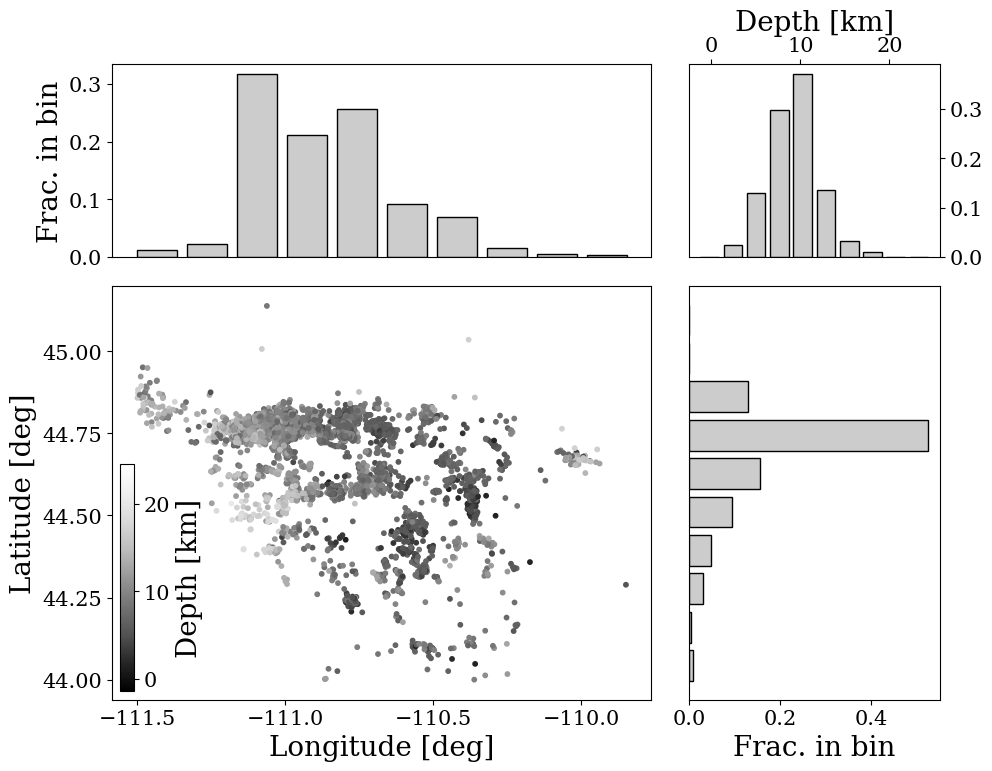

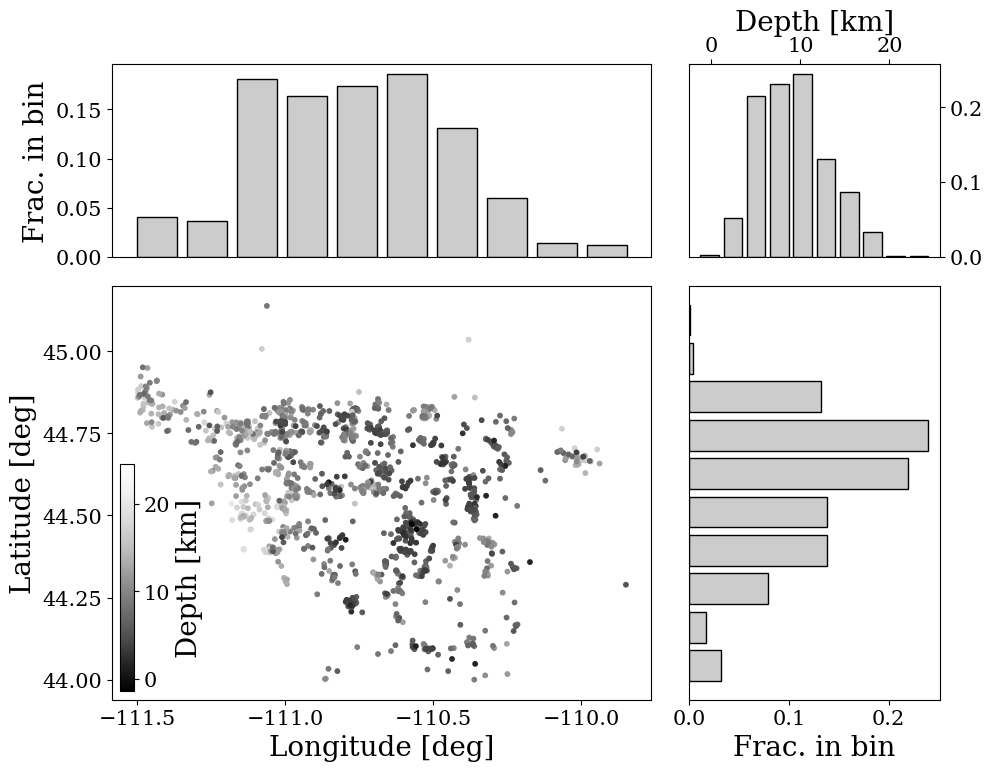

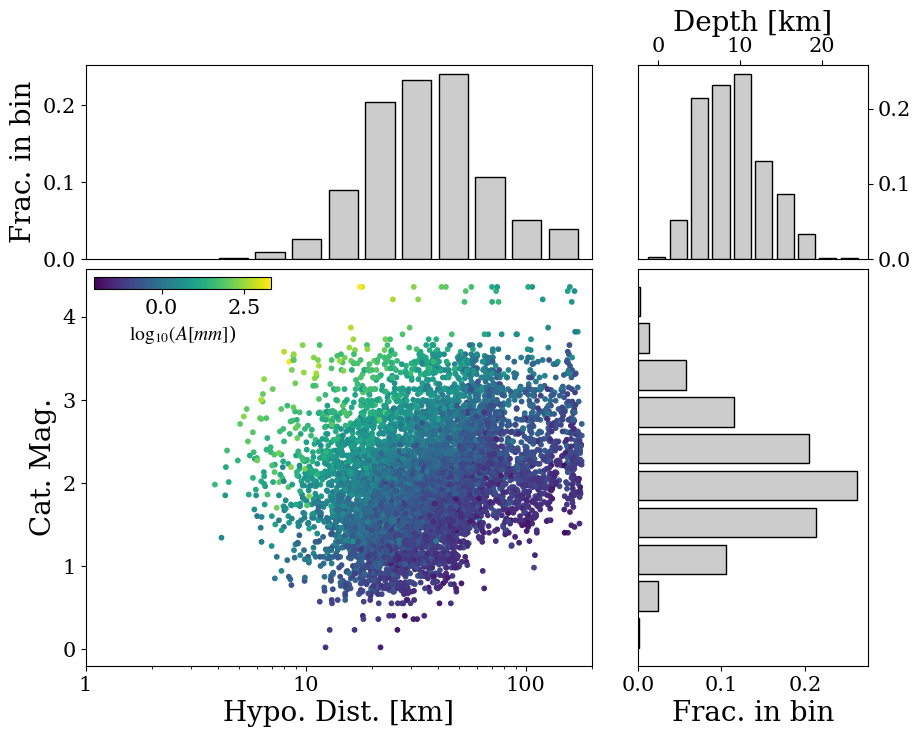

In [7]:
plt.show()